## **IDX Exchange Home Price Prediction**
## **Task 1: Data Exploration & Preprocessing**

#### 1. Imports & Setup

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob

#### 2. Load and Merge Raw CRMLS Files

In [2]:
data_path = Path("../data")

csv_files = glob.glob(str(data_path / "CRMLSSold*.csv"))
print("Found CSVs:", [Path(f).name for f in csv_files])

if not csv_files:
    raise FileNotFoundError(f"No CRMLSSold*.csv files found in {data_path.resolve()}")

Found CSVs: ['CRMLSSold202508.csv', 'CRMLSSold202503.csv', 'CRMLSSold202502.csv', 'CRMLSSold202505.csv', 'CRMLSSold202504.csv', 'CRMLSSold202506.csv', 'CRMLSSold202507.csv']


In [3]:
# Merge all monthly CRMLS datasets
df_list = [pd.read_csv(f) for f in csv_files]
df_all_raw = pd.concat(df_list, ignore_index=True)
print("Merged shape:", df_all_raw.shape)

# Save merged dataset
output_path = data_path / "all_raw.csv"
df_all_raw.to_csv(output_path, index=False)
print(f"Saved merged dataset → {output_path}")

/var/folders/4m/_gbynxg10v9__2c2z52hgcnm0000gn/T/ipykernel_10495/1724506622.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(f) for f in csv_files]


Merged shape: (156064, 78)
Saved merged dataset → ../data/all_raw.csv


#### 3. Filter Relevant Property Types

In [4]:
df_all = df_all_raw.copy()
if {"PropertyType", "PropertySubType"}.issubset(df_all.columns):
    df_all["PropertySubType"] = df_all["PropertySubType"].astype(str)
    mask_pt = df_all["PropertyType"].str.contains("residential", case=False, na=False)
    mask_ps = df_all["PropertySubType"].str.contains("single", case=False, na=False)
    df_all = df_all[mask_pt & mask_ps]

print("After filtering Residential/SFR:", df_all.shape)

After filtering Residential/SFR: (95606, 78)


#### 4. Clean Target and Handle Outliers

In [5]:
target_candidates = ["ClosePrice", "Close Price", "Close_Price", "CLOSEPRICE"]
target = next((c for c in target_candidates if c in df_all.columns), None)
assert target is not None, f"Target not found. Tried: {target_candidates}"

df_all = df_all[df_all[target].between(50_000, 10_000_000)]
df_all = df_all.dropna(subset=[target])
print("After removing outliers & NaNs:", df_all.shape)

After removing outliers & NaNs: (78396, 78)


#### 5. Feature Engineering

In [6]:
living_candidates = ["LivingArea", "Living Area", "SQFT", "SquareFootage", "Square_Footage"]
living = next((c for c in living_candidates if c in df_all.columns), None)
if living:
    df_all["PricePerSqft"] = df_all[target] / df_all[living].clip(lower=1)
    print("Added feature PricePerSqft")

Added feature PricePerSqft


#### 6. Save Cleaned Dataset

In [7]:
data_path = Path("../data")
df_clean = df_all.reset_index(drop=True)
output_file = data_path / "cleaned_enhanced.csv"
df_clean.to_csv(output_file, index=False)
print(f"Saved cleaned dataset → data/cleaned_enhanced.csv | Shape: {df_clean.shape}")

Saved cleaned dataset → data/cleaned_enhanced.csv | Shape: (78396, 79)


#### 7. Visualization

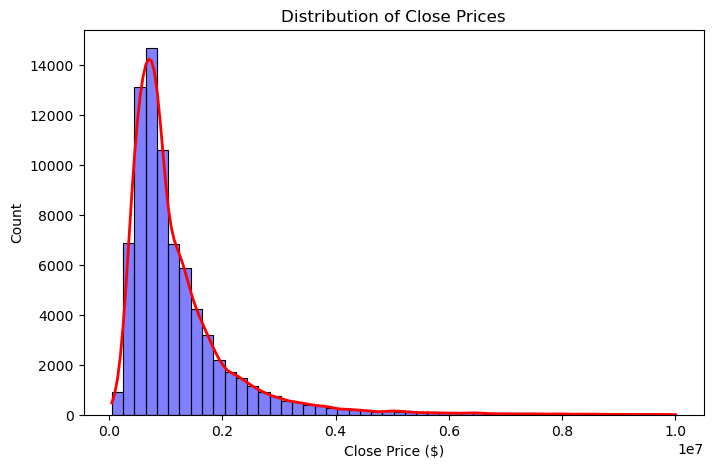

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Close Prices
plt.figure(figsize=(8,5))
ax = sns.histplot(
    df_clean["ClosePrice"],
    bins=50,
    kde=True,
    color="blue"   
)

for line in ax.lines:
    line.set_color("red")
    line.set_linewidth(2)

plt.title("Distribution of Close Prices")
plt.xlabel("Close Price ($)")
plt.ylabel("Count")
plt.show()


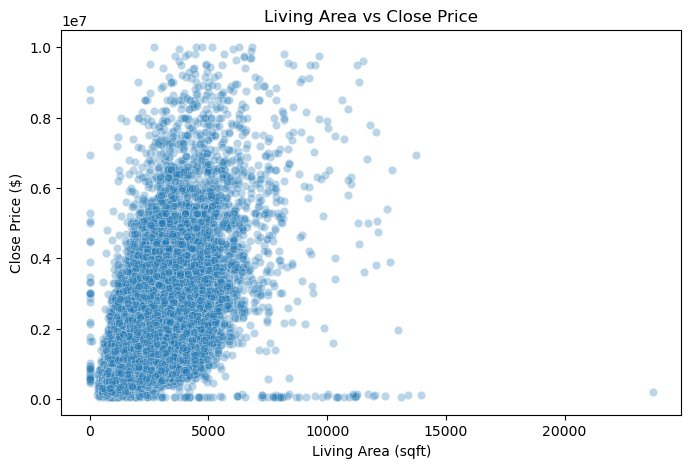

In [9]:
# Living Area vs Close Price
plt.figure(figsize=(8,5))
sns.scatterplot(x="LivingArea", y="ClosePrice", data=df_clean, alpha=0.3)
plt.title("Living Area vs Close Price")
plt.xlabel("Living Area (sqft)")
plt.ylabel("Close Price ($)")
plt.show()


From the plots above:
- Most property close prices fall below $2M, with a right-skewed distribution.
- There is a clear positive relationship between living area and property price.
- This validates that **LivingArea** and related features are strong predictors for our model training in Task 2.


#### 8. Quick Summary

In [10]:
display(df_clean.head())

,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,...,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,PricePerSqft
0,SanDiego,SanDiego,Bamboo,True,NaN,NaN,False,2800000.0,1130907846,vickicoronado@gmail.com,...,NaN,NaN,False,2.0,NaN,92118,325.0,NaN,NaN,943.396226
1,PacificSouthwest,PacificSouthwest,NaN,False,NaN,NaN,True,1675000.0,1130879923,jennifer@homesbystclair.com,...,0.79,1.0,NaN,2.0,Chula Vista Elementary,91910,0.0,34412.4,NaN,442.887361
2,Mlslistings,Mlslistings,NaN,False,NaN,NaN,NaN,NaN,1130834243,susan@susanwoods.com,...,8023.00,NaN,False,2.0,Other,95032,NaN,8023.0,NaN,1461.949266
3,Mlslistings,Mlslistings,NaN,False,NaN,NaN,NaN,2500000.0,1130746481,bbarnes@intero.com,...,6000.00,NaN,False,2.0,Other,94087,NaN,6000.0,NaN,1636.125654
4,SierraNorthValley,SierraNorthValley,"Tile,Vinyl",True,NaN,NaN,False,660000.0,1130727503,doug@realspeicher.com,...,26572.00,3.0,False,2.0,Paradise Unified,95969,0.0,26572.0,NaN,309.423347


In [11]:
display(df_clean.describe(include='all').transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
BuyerAgentAOR,78386,53,OrangeCounty,5807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ListAgentAOR,78386,53,OrangeCounty,5807,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flooring,50658,234,"Carpet,Tile",5571,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViewYN,71129,2,True,43523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WaterfrontYN,36,1,True,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
PostalCode,78395,1741,92253,625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AssociationFee,55294.0,NaN,NaN,NaN,102.294417,298.993909,0.0,0.0,0.0,130.0,19918.0
LotSizeSquareFeet,77031.0,NaN,NaN,NaN,208714.246327,13052431.134165,0.0,5663.0,7300.0,10454.0,2087220960.0
MiddleOrJuniorSchoolDistrict,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
